In [2]:
import numpy as np
import pandas as pd
from native_fold import *

## Functions

Generating Shapes & Path

In [3]:
def index_shape(shape):
    '''
    Numbers the elements of an input array from 1, starting horizontally
        Input: shape - numpy array of 0's and 1's representing shape
        Output: shape_out - numpy array with indexed elements for non-zero elements padded with 0 (void)
    '''
    # gets shape dimensions
    row_len = np.shape(shape)[0] # gets row length
    col_len = np.shape(shape)[1] # gets col length
    shape_out = np.asarray(row_len * [col_len * [0]])
    
    index = 1 # path starts from 1
    for row in range(row_len): # goes through each row
        for col in range(col_len): # goes through each column
            if shape[row][col] == 1: # if element present
                shape_out[row][col] = index
                index += 1

    return np.pad(shape_out, 1) # pads with 0 for void

In [4]:
def gen_path(df, shape, origin):
    '''
    Generates all possible paths given a shape
        Input: df - pandas dataframe containing neighbouring environment information of the shape 
               shape - numpy array with indexed elements for non-zero elements padded with 0 (void)
               origin - location (tuple) of point to start from on the shape
        Output: paths - list of all possible paths for a given shape
    '''
    # generate all possible paths and stored in paths
    paths = [] # list of all possible paths
    visited = set()
    length = len(df)
    def saw(start, visited, path=[]):
        # intialising path
        if start not in path:
            path.append(start)
            visited.add(start)

        # growing the path
        if len(path) < length: # if chain not finished
            curr_i = shape[start[0]][start[1]] # name of the current element
            nb_list = df.loc[curr_i].loc["neighbours"] # list of neighbours for the element

            for nb in nb_list: # iteratres through each neighbour
                nb_pos = df.loc[nb].loc["position"]
                if nb_pos not in visited: # if neighbour has not been visted
                    visited.add(nb_pos)
                    saw(nb_pos, visited, path + [nb_pos])
                    visited.remove(nb_pos)
        else:
            paths.append(path)
    saw(origin, visited)

    return paths

In [28]:
def optimal_path(df, shape):
    '''
    Returns the optimal paths given a shape judged by the number of elements in contact with the terminals
        Input: df - pandas dataframe containing neighbouring environment information of the shape 
        Output: optimal paths with the most ends 'buried'
    '''
    # dictionary of how many total terminal neighbours paths have
    terminal_nb = {}
    for i in range(8,3,-1): # min number of connected neighbours for terminals = 4, maximum = 8
        terminal_nb[i] = [] # create empty list for path

    # dictionary of neighbour count and positions
    pos_to_nb = {}
    for i in range(len(df)):
        pos_to_nb[df.iloc[i].loc["position"]] = df.iloc[i].loc["nb count"]

    # generating path from each point in shape
    for i in range(len(df)):
        paths = []
        origin = df.iloc[i].loc["position"]
        paths = gen_path(df, shape, origin) # generate all possible paths starting from given origin
        for path in paths:
            term_nb = pos_to_nb[path[0]] + pos_to_nb[path[-1]] # calculate the total neighbours of the two terminals
            terminal_nb[term_nb].append(path)
    
    # remove repeating paths
    for i in range(8,3,-1):
        for path in terminal_nb[i]:
            if list(reversed(path)) in terminal_nb[i]:
                terminal_nb[i].remove(path)

    for i in range(8,3,-1):
        print(f"{len(terminal_nb[i])} paths for terminal neighbours = {i-2}")

    # return paths with specified terminal neighbours
    return terminal_nb

In [6]:
# def optimal_path(df, shape):
#     '''
#     Returns the optimal paths given a shape judged by the number of elements in contact with the terminals
#         Input: df - pandas dataframe containing neighbouring environment information of the shape 
#         Output: optimal paths with the most ends 'buried'
#     '''
#     both_ends = []
#     one_end = []
#     no_end = []

#     # get a list of all interior elements
#     interior_i = []
#     for i in range(1, len(df)+1):
#         if df.loc[i].loc["nb count"] == 4:
#             interior_i.append(i)
    
#     # get a list of all exterior elements
#     exterior_i = []
#     for i in range(1, len(df)+1):
#         if i not in interior_i:
#             exterior_i.append(i)

#     # generate path starting from interior
#     if len(interior_i) != 0:
#         for i in interior_i:
#             paths = []
#             i_pos = df.loc[i].loc["position"]
#             paths = gen_path(df, shape, i_pos) # generates all possible paths starting from each interior element

#             for path in paths: # for each path
#                 last_x, last_y = path[-1]
#                 if shape[last_x][last_y] in interior_i:
#                     both_ends.append(path)
#                 else:
#                     one_end.append(path)
#     # generate path from every exterior
#     else:
#         print("No interior element")
#         for i in exterior_i:
#             paths = []
#             i_pos = df.loc[i].loc["position"]
#             paths = gen_path(df, shape, i_pos)
#             for path in paths:
#                 no_end.append(path)

#     # reports output
#     if len(both_ends) != 0:
#         print("Optimal paths have both ends buried")
#         return both_ends
#     elif len(one_end) != 0:
#         print("Optimal paths have one end buried")
#         return one_end
#     elif len(no_end) != 0:
#         print("Optimal paths have no end buried")
#         return no_end
#     else:
#         print("No viable path for this shape")

Plot Paths & Shapes

In [7]:
def plot_path(path):
    plt.figure(figsize = (6, 6))
    x = []
    y = []
    for i in path:
        x.append(i[0])
        y.append(i[1])

    plt.plot(x, y, 'bo-', ms = 12, linewidth = 1)
    plt.plot(path[0][0], path[0][1], 'go', ms = 14, label = 'Start')
    plt.plot(path[-1][0], path[-1][1], 'ro', ms = 14, label = 'End')
    plt.axis('equal')
    plt.legend(fontsize=15)
    plt.show()

In [8]:
def plot_HP(sequence, path):
    plt.figure(figsize = (6, 6))

    # Gets positions of elements
    x_P = [] # position of P elements
    y_P = []
    for i in range(len(path)):
        if sequence[i] == "P":
            x_P.append(path[i][0])
            y_P.append(path[i][1])
    x = [] # position of all elements
    y = []
    for i in path:
        x.append(i[0])
        y.append(i[1])

    # Plots H & P with path
    plt.plot(x, y, 'ro-', ms = 12, linewidth = 1, label='H')
    plt.plot(x_P, y_P, 'bo', ms = 12, label='P')
    plt.legend(fontsize=15)
    
    plt.axis('equal')
    plt.show()

Get Environment Info

In [9]:
def get_env(shape):
    '''
    Gets the environment of each element before assigning path
        Input: shape - numpy array with indexed elements for non-zero elements padded with 0 (void)
        Output: dataframe including position, neighbours & neighbour count for each element
    '''
    # record position data
    pos = {} # dict of position
    for row in shape:
        for i in row:
            if i != 0: # if i is an element
                pos[i] = (np.where(shape==i)[0][0], np.where(shape==i)[1][0]) # coordinate of element as tuple

    # record neighbour data
    nb = {} # dict of neighbours
    for i in range(1, len(pos)+1):
        nb[i] = [] # generates empty dictionary for each indexed element
    coord_sum = {} # list of coordinate sums for finding neighbours
    for i in range(1, len(pos)+1):
        coord_sum[i] = sum(pos[i])
    
    # find neighbours of each element according to coordinate sum
    for i1 in coord_sum: # for each element
        sum1 = coord_sum[i1] # coordinate sum
        if (sum1 % 2) == 0: # get elements with even coord sum
            for sum2 in [sum1-1, sum1+1]: # get elements with coord sum +-1 of sum1
                for i2 in coord_sum: # iterate through dictionary to find matching coord sum
                    if coord_sum[i2] == sum2: # if the sum matches
                        i1_pos = pos[i1]
                        i2_pos = pos[i2]
                        distance = (i1_pos[0] - i2_pos[0])**2 + (i1_pos[1] - i2_pos[1])**2 # calculates distance
                        if distance == 1: # neighbour
                            nb[i1].append(i2)
                            nb[i2].append(i1)      
    
    nb_count = {} # dict of neighbour numbers
    for i in range(1, len(pos)+1):
        nb_count[i] = len(nb[i])
    
    return pd.DataFrame({"position":pd.Series(pos), "neighbours":pd.Series(nb), "nb count":pd.Series(nb_count)})
    

In [10]:
def path_info(path, shape):
    '''
    Checks the surrounding environment of each connected element given a path
        Input: path - list of coordinates in order of the path
        Output: df - dataframe with environment information
    '''
    # get the element label for each path coordinate
    path_order = [] # list of element name in order for a given path
    for i in path:
        path_order.append(shape[i[0]][i[1]])#
    
    # record position data
    pos = {} # dict of position
    for row in shape:
        for i in row:
            if i != 0: # if i is an element
                pos[i] = (np.where(shape==i)[0][0], np.where(shape==i)[1][0]) # coordinate of element as tuple

    # record neighbour data
    nb = {} # dict of neighbours
    for i in range(1, len(path_order)+1): # i = element name
        nb[i] = [] # generates empty dictionary for each indexed element

    # find non-connected neighbours of each element using odd-even contact rule
    for idx_i in range(1,len(path_order),2): # even index
        i = path_order[idx_i] # element label
        i_pos = pos[i]
        for idx_j in range(0,len(path_order),2): # odd index
            j = path_order[idx_j] # element label

            if idx_j != (idx_i-1) and  idx_j != (idx_i+1):
                j_pos = pos[j]
                distance = (i_pos[0] - j_pos[0])**2 + (i_pos[1] - j_pos[1])**2 # calculates distance
                if distance == 1: # neighbour
                    nb[i].append(j)
                    nb[j].append(i)
    
    # counts how many non-connected neighbours an element has
    nb_count = {}
    for i in nb:
        nb_count[i] = len(nb[i])

    df = pd.DataFrame({"position":pd.Series(pos), "contact":pd.Series(nb), "contact number":pd.Series(nb_count)})

    return df

Assigning HP

In [11]:
def assign_HP(path, shape):
    '''
    Assigns H or P to each element, according to rule set 1, H = 1, P = -1
    Rule set 1:
        Assign H's to all interior residues
        Assign H's to all exterior residues in contact with interior residues
    '''
    # creates array copy with the same dimension
    row_n = np.shape(shape)[0] # gets row number
    col_n = np.shape(shape)[1] # gets col number
    shape1 = np.asarray(row_n*[col_n*[0]])

    # get neighbour information
    df = path_info(path, shape)

    # list of interior & exterior H's
    interior_H = []
    exterior_H = []

    # find interior H & assign H
    for i in range(1,len(df)+1):
        if df.loc[i].loc["contact number"] >= 2: # interior
            interior_H.append(i)

    # choose exterior residue to assign H
    for i in interior_H: # each interior H
        for j in df.loc[i].loc["contact"]: # contact of each interior H
            if j not in interior_H: # finds only exterior contact
                exterior_H.append(j)
    if len(interior_H) == 0: # if no interior
        for i in range(1,len(df)+1):
            if df.loc[i].loc["contact number"] >= 1:
                exterior_H.append(i)

    # assign H & P
    residue = {}
    sequence = []
    for i in range(len(df)): # index
        j = df.iloc[i].name # element name
        if len(interior_H) != 0:
            if (j in interior_H) or (j in exterior_H): # check if assigned H
                shape1[df.iloc[i].loc["position"][0]][df.iloc[i].loc["position"][1]] = 1 # H
                residue[j] = 'H'
            else:
                shape1[df.iloc[i].loc["position"][0]][df.iloc[i].loc["position"][1]] = -1 # P
                residue[j] = 'P'
        else:
            if j in exterior_H:
                shape1[df.iloc[i].loc["position"][0]][df.iloc[i].loc["position"][1]] = 1 # H
                residue[j] = 'H'
            else:
                shape1[df.iloc[i].loc["position"][0]][df.iloc[i].loc["position"][1]] = -1 # P
                residue[j] = 'P'

    df["residue"] = pd.Series(residue)

    for pos in path:
        i = shape[pos[0]][pos[1]]
        sequence.append(residue[i])

    return shape1, df, "".join(sequence)

Calculate Energy & Degeneracy

In [12]:
def calc_energy(df):
    '''
    Calculates energy of the outputted array with H & P
    '''
    energy = 0
    for i in range(len(df)):
        if df.iloc[i].loc["residue"] == "H":
            for j in df.iloc[i].loc["contact"]:
                if df.loc[j].loc["residue"] == "H":
                    energy += -1

    return energy/2

In [13]:
def min_EnD(sequence):
    seq = sequence
    n = len(sequence)
    paths = native_fold(n)
    energies = compute_energy(paths, sequence)
    min_energy = energies[0][0]
    degeneracy = 0

    for i in energies:
        if i[0] == min_energy:
           degeneracy += 1
        
        # # plot the path 
        # path = heapq.heappop(energies)
        # x = [coord[0] for coord in path[1]]
        # y = [coord[1] for coord in path[1]]
        # # print h and p on graph
        # for i in range(n):
        #     if sequence[i] == 'H':
        #         plt.text(x[i], y[i], 'H')
        #     else:
        #         plt.text(x[i], y[i], 'P')
        # plt.plot(x, y, 'ro')
        # plt.plot(x, y)
        # plt.show()
    
    return min_energy, degeneracy

## Procedural Design

In [31]:
# generates indexed structure given a shape
structure = np.asarray([[0,0,0,1,1,1],
                        [1,1,1,1,1,1],
                        [1,1,1,1,1,1],
                        [0,0,0,0,0,0]], dtype=int) # shape of 0 and 1
structure = index_shape(structure) # shape of indexed elements
print(structure)

# generates dataframe of neighbour information
seq_df = get_env(structure)

# Check the optimal number of terminal neighbours
paths_dict = optimal_path(seq_df, structure) # paths_dict[8] == 6 nb count

[[ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  2  3  0]
 [ 0  4  5  6  7  8  9  0]
 [ 0 10 11 12 13 14 15  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]
0 paths for terminal neighbours = 6
6 paths for terminal neighbours = 5
9 paths for terminal neighbours = 4
18 paths for terminal neighbours = 3
15 paths for terminal neighbours = 2


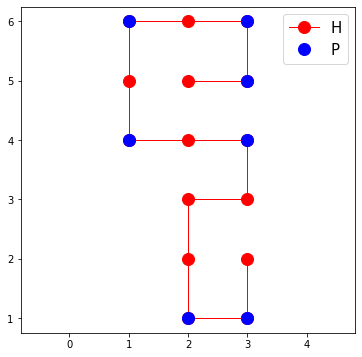

[24, 24, 2]


In [32]:
# get solution with minimum degeneracy or below a certain threshold
degeneracy = []
paths = paths_dict[7]
for path in paths:
    __, __, sequence = assign_HP(path, structure)
    __, deg = min_EnD(sequence)
    degeneracy.append(deg)
    if deg == 2:
        plot_HP(sequence, path)
        break
print(degeneracy)

## Testing

Visualising

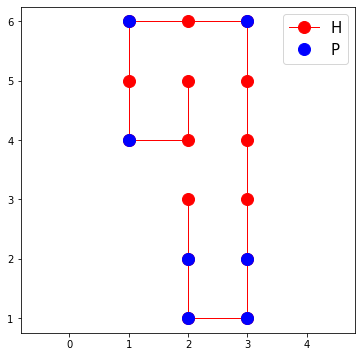

Energy: -6.0
Minimum Energy: -6
Degeneracy 24
HPPPPHHHPHPHPHH


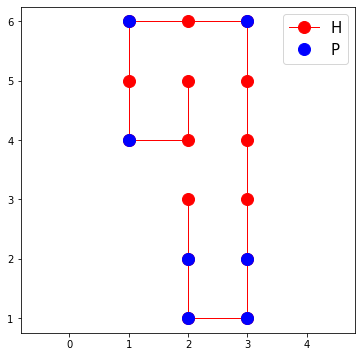

Energy: -6.0
Minimum Energy: -6
Degeneracy 24
HHPHPHPHHHPPPPH


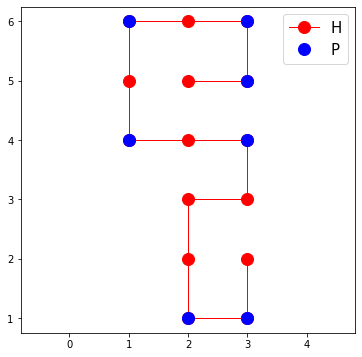

Energy: -6.0
Minimum Energy: -7
Degeneracy 2
HPPHPHPHPHHHPPH


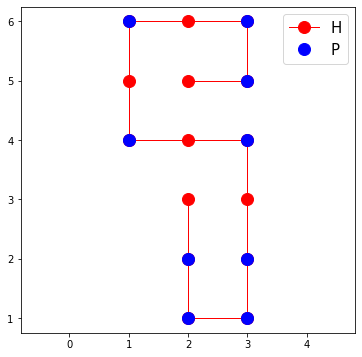

Energy: -5.0
Minimum Energy: -5
Degeneracy 18
HPPHPHPHPHPPPPH


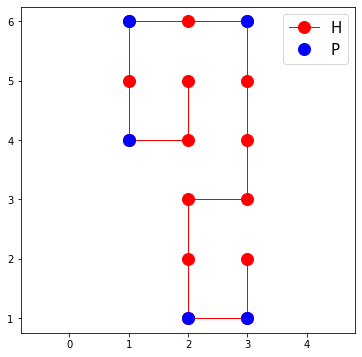

Energy: -7.0
Minimum Energy: -7
Degeneracy 44
HPPHHHHHPHPHPHH


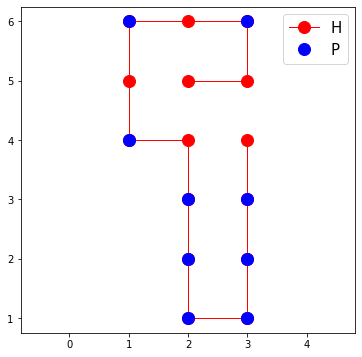

Energy: -5.0
Minimum Energy: -5
Degeneracy 14
HPPPPPPHPHPHPHH


In [33]:
for path in paths:
    _, seq_df1, sequence = assign_HP(path, structure)
    min_energy, deg = min_EnD(sequence)
    plot_HP(sequence, path)
    print(f"Energy: {calc_energy(seq_df1)}")
    print(f"Minimum Energy: {min_energy}")
    print(f"Degeneracy {deg}")
    print(sequence)